# 🔥 Building Rockpool modules with Torch

## Use the Rockpool Torch-backed classes

In [22]:
# - Switch off warnings
import warnings

warnings.filterwarnings("ignore")

# - Rich printing
try:
    from rich import print
except:
    pass

# - Import and configure matplotlib for plotting
import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

# - Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

In [69]:
from rockpool.nn.modules import RateTorch, LinearTorch
from rockpool.nn.combinators import Sequential

Nin = 2
Nhidden = 5
Nout = 2

# Define a simple feed-forward network using the Torch backend
net = Sequential(
    LinearTorch((Nin, Nhidden)),
    RateTorch((Nhidden,)),
    nn.Dropout2d(0.25),
    LinearTorch((Nhidden, Nout)),
    RateTorch((Nout,)),
)
net

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 5)
    RateTorch '1_RateTorch' with shape (5,)
    Dropout2d '2_Dropout2d' with shape (None,)
    LinearTorch '3_LinearTorch' with shape (5, 2)
    RateTorch '4_RateTorch' with shape (2,)
}

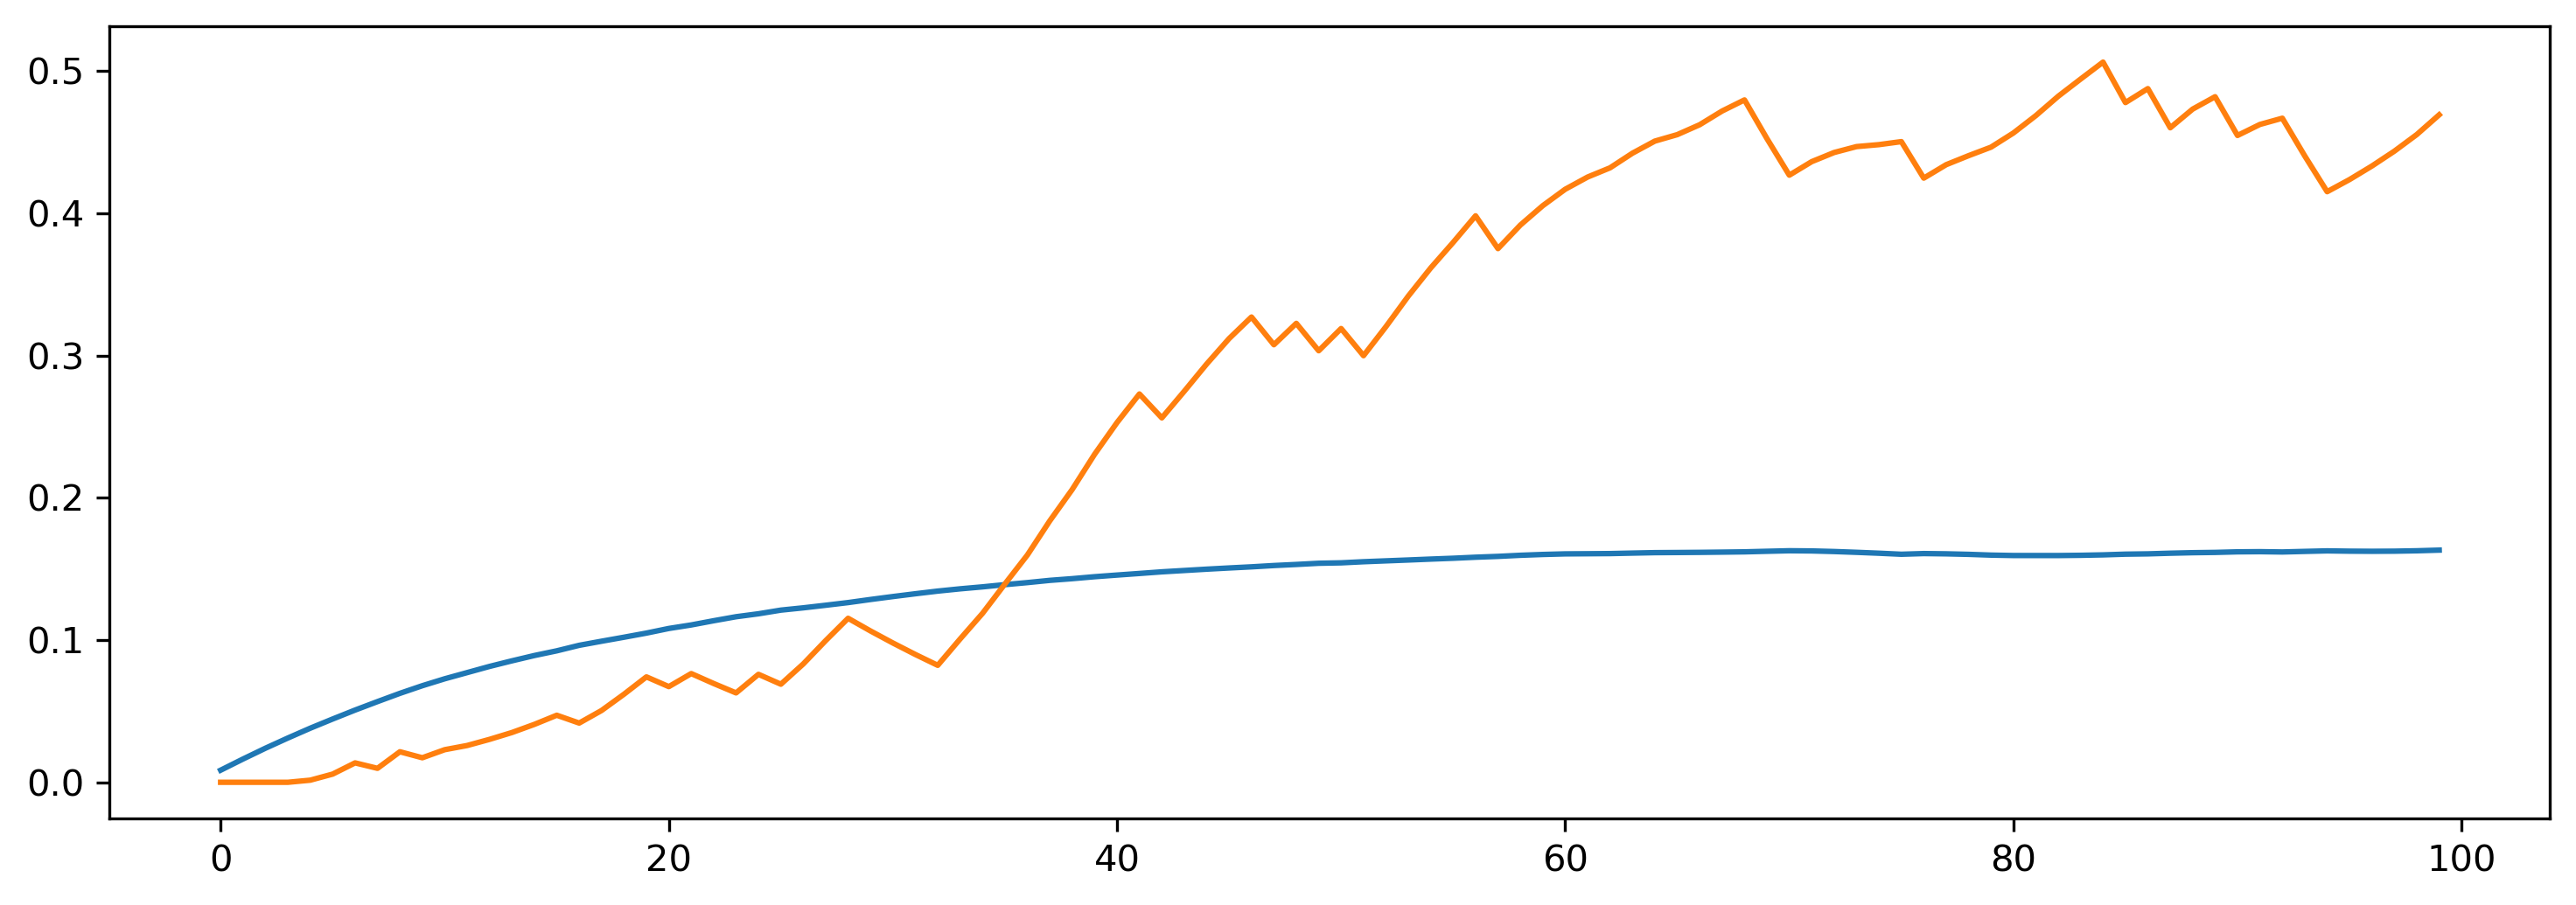

In [70]:
# - Evolve the network on random data and plot
data = torch.rand((1, 100, Nin))
out, _, _ = net(data)
plt.plot(out[0].detach());

In [71]:
# - Recording internal signals also works
out, _, rd = net(data, record=True)
print(list(rd.keys()))

[
    '0_LinearTorch',
    '0_LinearTorch_output',
    '1_RateTorch',
    '1_RateTorch_output',
    '2_Dropout2d',
    '2_Dropout2d_output',
    '3_LinearTorch',
    '3_LinearTorch_output',
    '4_RateTorch',
    '4_RateTorch_output'
]

## Convert an existing Torch ``torch.nn.module`` for use in Rockpool

In [72]:
# - Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# - Rockpool imports
from rockpool.nn.modules import TorchModule

# - Implement a Torch class
class TorchNet(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # - Build some convolutional layers
        self.conv1 = nn.Conv2d(1, 2, 3, 1)

        # - Add a dropout layer
        self.dropout1 = nn.Dropout2d(0.25)

        # - Fully-connected layer
        self.fc1 = nn.Linear(338, 10)

        # - Register an example buffer
        self.register_buffer("test_buf", torch.zeros(3, 4))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        output = F.log_softmax(x, dim=1)
        return output

In [73]:
# - Instantiate the network and test the Torch API

# Equates to one random 28x28 image
random_data = torch.rand((1, 1, 28, 28))

# - Generate torch module and test evaluation
mod = TorchNet()
result = mod(random_data)

In [74]:
# - Convert object to Rockpool API, in-place
TorchModule.from_torch(mod)
print(mod)

TorchNet 'TorchModulePatch' with shape (None,) {
    Conv2d 'TorchModulePatch' with shape (None,)
    Dropout2d 'TorchModulePatch' with shape (None,)
    Linear 'TorchModulePatch' with shape (None,)
}

In [75]:
# - Use the Rockpool API to evolve the module
output, _, _ = mod(random_data)
print(output)

tensor([[-2.2458, -1.9656, -2.3617, -2.3617, -2.3617, -2.3617, -2.3617, -2.3617,
         -2.3617, -2.3617]], grad_fn=<LogSoftmaxBackward0>)

In [76]:
# - Use the Rockpool API to access parameters
print("Parameters: ", mod.parameters())
print("State: ", mod.state())

Parameters: 
{
    'conv1': {
        'weight': Parameter containing:
tensor([[[[-0.1636, -0.3071,  0.0886],
          [ 0.1826, -0.0988, -0.2805],
          [ 0.1841, -0.1396, -0.0389]]],


        [[[ 0.2814, -0.2359, -0.0974],
          [-0.2386,  0.3125,  0.1958],
          [ 0.3165,  0.0791, -0.0173]]]], requires_grad=True),
        'bias': Parameter containing:
tensor([-0.1282,  0.0541], requires_grad=True)
    },
    'dropout1': {},
    'fc1': {
        'weight': Parameter containing:
tensor([[ 0.0261, -0.0336, -0.0126,  ..., -0.0055,  0.0495, -0.0540],
        [ 0.0469,  0.0163, -0.0500,  ..., -0.0408, -0.0364, -0.0121],
        [-0.0284,  0.0247,  0.0290,  ..., -0.0128,  0.0444,  0.0534],
        ...,
        [ 0.0184,  0.0500,  0.0326,  ..., -0.0116, -0.0092,  0.0071],
        [ 0.0190,  0.0424, -0.0505,  ..., -0.0379, -0.0238,  0.0469],
        [ 0.0119,  0.0063,  0.0538,  ..., -0.0211, -0.0373,  0.0374]],
       requires_grad=True),
        'bias': Parameter containing:
tensor([-0.0106, -0.0069, -0.0463,  0.0346,  0.0390, -0.0147, -0.0386, -0.0023,
         0.0171, -0.0368], requires_grad=True)
    }
}

State: 
{
    'test_buf': tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
    'conv1': {},
    'dropout1': {},
    'fc1': {}
}

In [77]:
# - Convert the parameter dictionary to torch parameters
print("Parameters.astorch(): ", list(mod.parameters().astorch()))

Parameters.astorch(): 
[
    Parameter containing:
tensor([[[[-0.1636, -0.3071,  0.0886],
          [ 0.1826, -0.0988, -0.2805],
          [ 0.1841, -0.1396, -0.0389]]],


        [[[ 0.2814, -0.2359, -0.0974],
          [-0.2386,  0.3125,  0.1958],
          [ 0.3165,  0.0791, -0.0173]]]], requires_grad=True),
    Parameter containing:
tensor([-0.1282,  0.0541], requires_grad=True),
    Parameter containing:
tensor([[ 0.0261, -0.0336, -0.0126,  ..., -0.0055,  0.0495, -0.0540],
        [ 0.0469,  0.0163, -0.0500,  ..., -0.0408, -0.0364, -0.0121],
        [-0.0284,  0.0247,  0.0290,  ..., -0.0128,  0.0444,  0.0534],
        ...,
        [ 0.0184,  0.0500,  0.0326,  ..., -0.0116, -0.0092,  0.0071],
        [ 0.0190,  0.0424, -0.0505,  ..., -0.0379, -0.0238,  0.0469],
        [ 0.0119,  0.0063,  0.0538,  ..., -0.0211, -0.0373,  0.0374]],
       requires_grad=True),
    Parameter containing:
tensor([-0.0106, -0.0069, -0.0463,  0.0346,  0.0390, -0.0147, -0.0386, -0.0023,
         0.0171, -0.0368], requires_grad=True)
]

## Write a native Rockpool/Torch module using ``TorchModule``

In [78]:
# - Implement a Rockpool class using the TorchModule base class
class RockpoolNet(TorchModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # - Build some convolutional layers
        self.conv1 = nn.Conv2d(1, 2, 3, 1)

        # - Add a dropout layer
        self.dropout1 = nn.Dropout2d(0.25)

        # - Fully-connected layer
        self.fc1 = nn.Linear(338, 10)

        # - Register an example buffer
        self.register_buffer("test_buf", torch.zeros(3, 4))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        output = F.log_softmax(x, dim=1)
        return output

In [79]:
# - Instantiate the Rockpool class directly
rmod = RockpoolNet()
print(rmod)

RockpoolNet  with shape (None,) {
    Conv2d 'conv1' with shape (None,)
    Conv2d 'conv1' with shape (None,)
    Dropout2d 'dropout1' with shape (None,)
    Dropout2d 'dropout1' with shape (None,)
    Linear 'fc1' with shape (None,)
    Linear 'fc1' with shape (None,)
}

In [80]:
# - Evaluate the module using the Rockpool API
output, _, _ = rmod(random_data)
print(output)

tensor([[-2.3283, -2.3283, -2.3283, -2.3283, -2.3283, -2.2359, -2.2393, -2.2600,
         -2.3283, -2.3283]], grad_fn=<LogSoftmaxBackward0>)

In [81]:
# - Access parameters using the Rockpool API
print("Parameters: ", rmod.parameters())
print("State: ", rmod.state())

Parameters: 
{
    'conv1': {
        'weight': Parameter containing:
tensor([[[[ 0.2828, -0.2562,  0.0924],
          [ 0.1476,  0.0577, -0.0121],
          [ 0.0073,  0.2832, -0.2923]]],


        [[[ 0.2786,  0.0777, -0.0933],
          [-0.1199,  0.0570, -0.2343],
          [ 0.2991,  0.0064, -0.2985]]]], requires_grad=True),
        'bias': Parameter containing:
tensor([-0.2721, -0.2435], requires_grad=True)
    },
    'dropout1': {},
    'fc1': {
        'weight': Parameter containing:
tensor([[-0.0320,  0.0249, -0.0329,  ...,  0.0196,  0.0241, -0.0021],
        [-0.0400,  0.0448, -0.0266,  ..., -0.0056, -0.0111,  0.0318],
        [ 0.0204,  0.0127, -0.0184,  ...,  0.0482, -0.0074,  0.0258],
        ...,
        [ 0.0328, -0.0477,  0.0297,  ..., -0.0182, -0.0296,  0.0217],
        [-0.0037,  0.0421,  0.0048,  ...,  0.0057, -0.0409, -0.0112],
        [-0.0214, -0.0465, -0.0319,  ...,  0.0304, -0.0220, -0.0306]],
       requires_grad=True),
        'bias': Parameter containing:
tensor([ 0.0059,  0.0042, -0.0443,  0.0200,  0.0258,  0.0406,  0.0433, -0.0303,
         0.0038,  0.0473], requires_grad=True)
    }
}

State: 
{
    'test_buf': tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
    'conv1': {},
    'dropout1': {},
    'fc1': {}
}

## Converting from Rockpool/torch to pure torch

### Rockpool API

In [82]:
# - Instantiate the Rockpool class
net = RockpoolNet()
print(net)

RockpoolNet  with shape (None,) {
    Conv2d 'conv1' with shape (None,)
    Conv2d 'conv1' with shape (None,)
    Dropout2d 'dropout1' with shape (None,)
    Dropout2d 'dropout1' with shape (None,)
    Linear 'fc1' with shape (None,)
    Linear 'fc1' with shape (None,)
}

In [83]:
# - Rockpool dictionary-based parameter API
print("Parameters:", net.parameters())

Parameters:
{
    'conv1': {
        'weight': Parameter containing:
tensor([[[[-0.2905,  0.1654, -0.1893],
          [-0.0804,  0.1523, -0.3320],
          [ 0.0346,  0.1020,  0.0288]]],


        [[[-0.1374,  0.3117,  0.0558],
          [-0.3279,  0.1651,  0.3008],
          [ 0.0011,  0.1701, -0.1425]]]], requires_grad=True),
        'bias': Parameter containing:
tensor([-0.1574, -0.1525], requires_grad=True)
    },
    'dropout1': {},
    'fc1': {
        'weight': Parameter containing:
tensor([[ 0.0269, -0.0310,  0.0103,  ..., -0.0044, -0.0114, -0.0388],
        [ 0.0409, -0.0286,  0.0256,  ...,  0.0166,  0.0072, -0.0476],
        [-0.0356,  0.0108, -0.0136,  ..., -0.0108,  0.0268,  0.0322],
        ...,
        [-0.0467, -0.0277,  0.0084,  ..., -0.0023,  0.0034, -0.0107],
        [-0.0191,  0.0524, -0.0005,  ...,  0.0305,  0.0221, -0.0304],
        [-0.0199,  0.0537,  0.0393,  ..., -0.0248,  0.0081,  0.0438]],
       requires_grad=True),
        'bias': Parameter containing:
tensor([ 0.0454,  0.0186, -0.0167, -0.0339,  0.0249,  0.0274, -0.0339, -0.0019,
        -0.0250, -0.0271], requires_grad=True)
    }
}

In [84]:
# Evaluate one random 28x28 image
random_data = torch.rand((1, 1, 28, 28))

# - Rockpool standard calling semantics
print(net(random_data))

(
    tensor([[-2.3239, -2.3239, -2.2561, -2.2330, -2.3239, -2.3239, -2.3239, -2.3239,
         -2.2750, -2.3239]], grad_fn=<LogSoftmaxBackward0>),
    {
        'test_buf': tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
        'conv1': {},
        'dropout1': {},
        'fc1': {}
    },
    {}
)

### Torch API

In [85]:
# - Convert in-place to the pure Torch API
net.to_torch()
print(net)

RockpoolNet(
  (conv1): Conv2d 'conv1' with shape (None,)
  (dropout1): Dropout2d 'dropout1' with shape (None,)
  (fc1): Linear 'fc1' with shape (None,)
)

In [86]:
# - Now returns the torch parameters API
print("Parameters:", list(net.parameters()))

Parameters:
[
    Parameter containing:
tensor([[[[-0.2905,  0.1654, -0.1893],
          [-0.0804,  0.1523, -0.3320],
          [ 0.0346,  0.1020,  0.0288]]],


        [[[-0.1374,  0.3117,  0.0558],
          [-0.3279,  0.1651,  0.3008],
          [ 0.0011,  0.1701, -0.1425]]]], requires_grad=True),
    Parameter containing:
tensor([-0.1574, -0.1525], requires_grad=True),
    Parameter containing:
tensor([[ 0.0269, -0.0310,  0.0103,  ..., -0.0044, -0.0114, -0.0388],
        [ 0.0409, -0.0286,  0.0256,  ...,  0.0166,  0.0072, -0.0476],
        [-0.0356,  0.0108, -0.0136,  ..., -0.0108,  0.0268,  0.0322],
        ...,
        [-0.0467, -0.0277,  0.0084,  ..., -0.0023,  0.0034, -0.0107],
        [-0.0191,  0.0524, -0.0005,  ...,  0.0305,  0.0221, -0.0304],
        [-0.0199,  0.0537,  0.0393,  ..., -0.0248,  0.0081,  0.0438]],
       requires_grad=True),
    Parameter containing:
tensor([ 0.0454,  0.0186, -0.0167, -0.0339,  0.0249,  0.0274, -0.0339, -0.0019,
        -0.0250, -0.0271], requires_grad=True)
]

In [87]:
# Evaluate one random 28x28 image
random_data = torch.rand((1, 1, 28, 28))

# - Now uses torch calling semantics
print(net(random_data))

tensor([[-2.3227, -2.3227, -2.3227, -2.2396, -2.3227, -2.3227, -2.3227, -2.3227,
         -2.2124, -2.3227]], grad_fn=<LogSoftmaxBackward0>)